<a href="https://colab.research.google.com/github/the-pinbo/image-denoising/blob/main/COLAB_model_with_gen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image Restoration without Denoised
##Mini Project in Image Processing
##EC386
###Members


1.   
```
Inbasekaran Perumal
201EC226
inba2002.p@gmail.com
```
2.   
```
Pranav Koundinya
201EC241
pranavmkoundinya@gmail.com
```

###Guide
```
Prof. Sumam David S
```


###Course Instructor
```
Prof. Deepu Vijayasenan
```

In [1]:
#@title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
#@title Tensor flow gpu check
import tensorflow as tf
tf.test.gpu_device_name()

2022-11-28 15:57:06.718393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-28 15:57:06.932141: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-28 15:57:06.932164: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-28 15:57:08.029463: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

''

To format the code do this 
```
!pip install black[jupyter]
!/content/drive/MyDrive/ImageProcessing/model.ipynb
```



In [3]:
#@title Importing Modules
import os
from matplotlib import image
from shutil import copyfile
import cv2
import seaborn as sns
import random
import PIL
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tensorflow import backend as K
import math
import time 
import pathlib
from sklearn.model_selection import train_test_split
tf.random.set_seed(0)

In [4]:
#@title Helper functions to navigate directories 

def make_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print("Made dir: ", path)
    else:
        print(f" {path} already exists")

def get_pwd():
    return os.getcwd()

def change_dir(path):
    os.chdir(path)
    print(f"Changed directory to {get_pwd()}")
    

def list_dir(path):
    return os.listdir(path)

In [5]:
#@title Define data root directory
data_root = "/content/drive/MyDrive/ImageProcessing/" #@param ["/content/drive/MyDrive/ImageProcessing/"] {allow-input: true}
change_dir(data_root)

Changed directory to /content/drive/MyDrive/ImageProcessing


In [6]:
#@title Define constant width and height
width = 256 #@param {type:"number"}
height = 256 #@param {type:"number"}

In [7]:
#@title mean and var
mean = 0 #@param {type:"number"}
var = .01 #@param {type:"number"}

In [9]:
#@title Download flickr8k dataset 
drive_colab_select = "colab" #@param ["drive", "none", "colab"]
name = "flickr8k" #@param ["flickr8k"]
origin_url = "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip" #@param ["https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip"] {allow-input: true}

if drive_colab_select == "drive":
    download_dir = data_root + "/dataset" + "/" + name
elif drive_colab_select == "colab":
    download_dir = "/content/dataset" + "/" + name
    make_dir(download_dir)

if drive_colab_select != "none":
    download_dataset(origin_url,download_dir)

Made dir:  /content/dataset/flickr8k
1115419746/1115419746 [==============================] - 69s 0us/step
Downloaded successfully in /content/dataset/flickr8k/Flickr8k_Dataset.zip


In [12]:
#@title Define noise dir and clean img dir
clean_img_sub_dir = "/Flicker8k_Dataset" #@param ["/Flicker8k_Dataset"] {allow-input: true}
clean_img_dir = download_dir + clean_img_sub_dir
noise_dir = download_dir + "/noise"
make_dir(noise_dir)
noise_dir = noise_dir + f"/m_{mean}__v_{var}".replace(".","d")
make_dir(noise_dir)
noise_1_dir = noise_dir + "/noise_1"
make_dir(noise_1_dir)
noise_2_dir = noise_dir + "/noise_2"
make_dir(noise_2_dir)

Made dir:  /content/dataset/flickr8k/noise
Made dir:  /content/dataset/flickr8k/noise/m_0__v_0d01
Made dir:  /content/dataset/flickr8k/noise/m_0__v_0d01/noise_1
Made dir:  /content/dataset/flickr8k/noise/m_0__v_0d01/noise_2


In [15]:
#@title Pre-Process the train images 
# preprocess and store images in their dir 
control = "yes" #@param ["yes", "no"]
if control == 'yes':
    preprocess_images(clean_img_dir,noise_1_dir,noise_2_dir)


Preprocessing 8091 images


100%|██████████| 8091/8091 [03:29<00:00, 38.54it/s]


In [16]:
#@title Helper functions to plot original noise1 and noise2 images 

def plot3(img_path, n_img_1_path, n_img_2_path):
    plt.figure(figsize=(15, 15))
    # plot clean image 
    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB))
    # plot noise 1
    plt.subplot(1, 3, 2)
    plt.title("Noisy Image 1")
    plt.imshow(cv2.cvtColor(cv2.imread(n_img_1_path), cv2.COLOR_BGR2RGB))
    # plot noise 2
    plt.subplot(1, 3, 3)
    plt.title("Noisy Image 2")
    plt.imshow(cv2.cvtColor(cv2.imread(n_img_2_path), cv2.COLOR_BGR2RGB))
    plt.show()


def plot_first_n(n):
    clean_img_paths = pathlib.Path(clean_img_dir).glob("*." + ext)
    for _ in range(n):
        img_path = next(clean_img_paths)
        img_name = str(img_path).split('/')[-1]
        n_img_1 = noise_1_dir + "/" + img_name
        n_img_2 = noise_2_dir + "/" + img_name
        plot3(str(img_path),n_img_1,n_img_2)

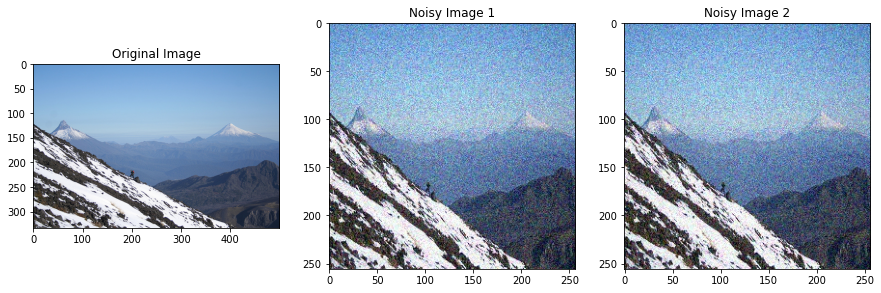

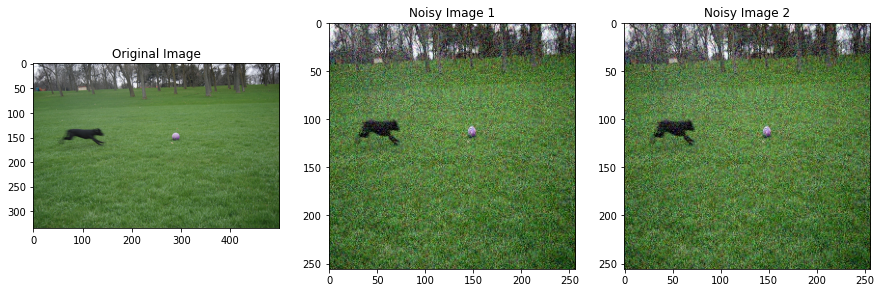

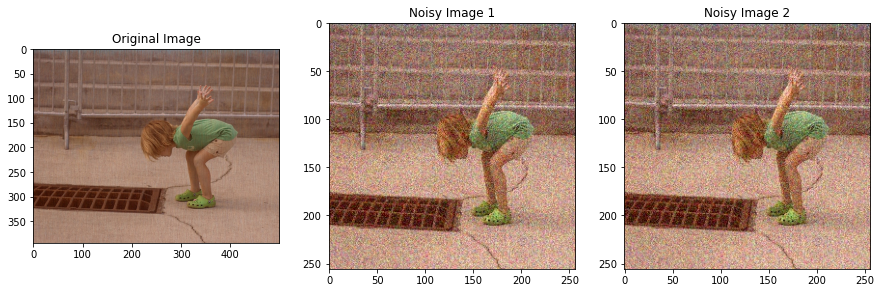

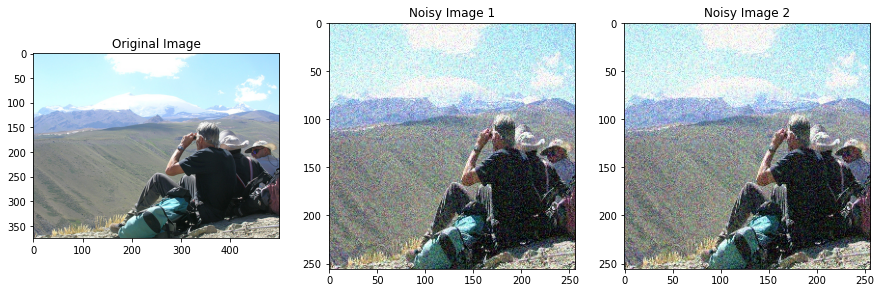

In [17]:
#@title Plot first n images original, noise 1 , noise 2
n = 4 #@param {type:"slider", min:1, max:15, step:1}
plot_first_n(n)

In [18]:
#@title generate image paths for noise1 and noise 2
def get_noise_img_path(clean_img_dir,noise_dir):
    return (noise_dir + "/" + name for name in get_name_list(clean_img_dir))


In [19]:
#@title Create File DataFrame 
noise_1_paths = pd.Series(get_noise_img_path(clean_img_dir,noise_1_dir), name='noise_1').astype(str)
noise_2_paths = pd.Series(get_noise_img_path(clean_img_dir,noise_2_dir), name='noise_2').astype(str)

In [20]:
noise_1_paths.describe()

count                                                  8091
unique                                                 8091
top       /content/dataset/flickr8k/noise/m_0__v_0d01/no...
freq                                                      1
Name: noise_1, dtype: object

In [21]:
noise_2_paths.describe()

count                                                  8091
unique                                                 8091
top       /content/dataset/flickr8k/noise/m_0__v_0d01/no...
freq                                                      1
Name: noise_2, dtype: object

In [22]:
images_df = pd.concat([noise_1_paths, noise_2_paths], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)
images_df.describe()

,noise_1,noise_2
count,8091,8091
unique,8091,8091
top,/content/dataset/flickr8k/noise/m_0__v_0d01/no...,/content/dataset/flickr8k/noise/m_0__v_0d01/no...
freq,1,1


In [23]:
train_size = 0.75 #@param {type:"slider", min:0, max:1, step:0.01}
train_df, test_df = train_test_split(images_df, train_size=train_size, shuffle=True, random_state=1)

In [24]:
train_df.describe()

,noise_1,noise_2
count,6068,6068
unique,6068,6068
top,/content/dataset/flickr8k/noise/m_0__v_0d01/no...,/content/dataset/flickr8k/noise/m_0__v_0d01/no...
freq,1,1


In [25]:
test_df.describe()

,noise_1,noise_2
count,2023,2023
unique,2023,2023
top,/content/dataset/flickr8k/noise/m_0__v_0d01/no...,/content/dataset/flickr8k/noise/m_0__v_0d01/no...
freq,1,1


In [26]:
#@title Defining batch size 
# Batch size
BATCH_SIZE = 64

In [27]:
#@title Defining our custom data generator 

class CustomDataGen(tf.keras.utils.Sequence):
    
    def __init__(self, df,
                 batch_size=BATCH_SIZE,
                 input_size=(height,width,3),
                 shuffle=True):
        
        self.df = df.copy()
        self.batch_size = batch_size
        self.input_size = input_size
        self.shuffle = shuffle
        self.n = len(self.df)
    
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __get_input(self, noise_1):
    
        image = tf.keras.preprocessing.image.load_img(noise_1)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        return image_arr/255.
    
    def __get_output(self, noise_2):
        image = tf.keras.preprocessing.image.load_img(noise_2)
        image_arr = tf.keras.preprocessing.image.img_to_array(image)
        return image_arr/255.
    
    def __get_data(self, batches):
        # Generates data containing batch_size samples

        noise_1_batch = batches["noise_1"]
        x_batch = np.asarray([self.__get_input(noise_1) for  noise_1 in noise_1_batch])

        noise_2_batch = batches["noise_2"]
        y_batch = np.asarray([self.__get_output(noise_2) for  noise_2 in noise_2_batch])

        return x_batch,y_batch
    
    def __getitem__(self, index):
        # X will be a NumPy array of shape (batch_size, input_height, input_width, input_channel)
        batches = self.df[index * self.batch_size:(index + 1) * self.batch_size]
        X, y = self.__get_data(batches)        
        return X, y
    
    def __len__(self):
        return self.n // self.batch_size

In [28]:
traingen = CustomDataGen(train_df)
print(f"Number of train batches {len(traingen)}")

Number of train batches 47


In [29]:
valgen = CustomDataGen(test_df)
print(f"Number of validation batches {len(valgen)}")

Number of validation batches 15


In [30]:
#@title Importing modules for training 
from tensorflow.keras.losses import MeanSquaredError
mse = tf.keras.losses.MeanSquaredError()
# mse(train_gaussian_noise_images[0], train_scans[0]).numpy()
from keras import Input, Model, Sequential
from keras import layers
from keras import backend as K
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers.experimental.preprocessing import (
    RandomFlip,
    RandomContrast,
    RandomRotation,
)
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Add
K.clear_session()

In [31]:
#@title Data augmentation


In [32]:
#@title Load a model if saved 
print("Do you want to load an existing model[yes/no]?")
opt = "no" #@param ["yes", "no"]
fileName = "/content/drive/MyDrive/ImageProcessing/dataset/models/baseline.h" #@param ["/content/drive/MyDrive/ImageProcessing/dataset/models/baseline.h"] {allow-input: true}
if opt == "yes":
    from keras import models
    model = models.load_model(fileName)
    print(model.summary())
    # print(model.get_weights())    
    # print(model.opttimizer())  


Do you want to load an existing model[yes/no]?


In [41]:
#@title Instantiation of model
architecture = "RedNet" #@param ["RedNet", "UNet"]
autoencoder = eval(architecture)()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv2d_23 (Conv2D)             (None, 256, 256, 16  448         ['sequential[2][0]']             
                                )                                                                 
                                                                                            

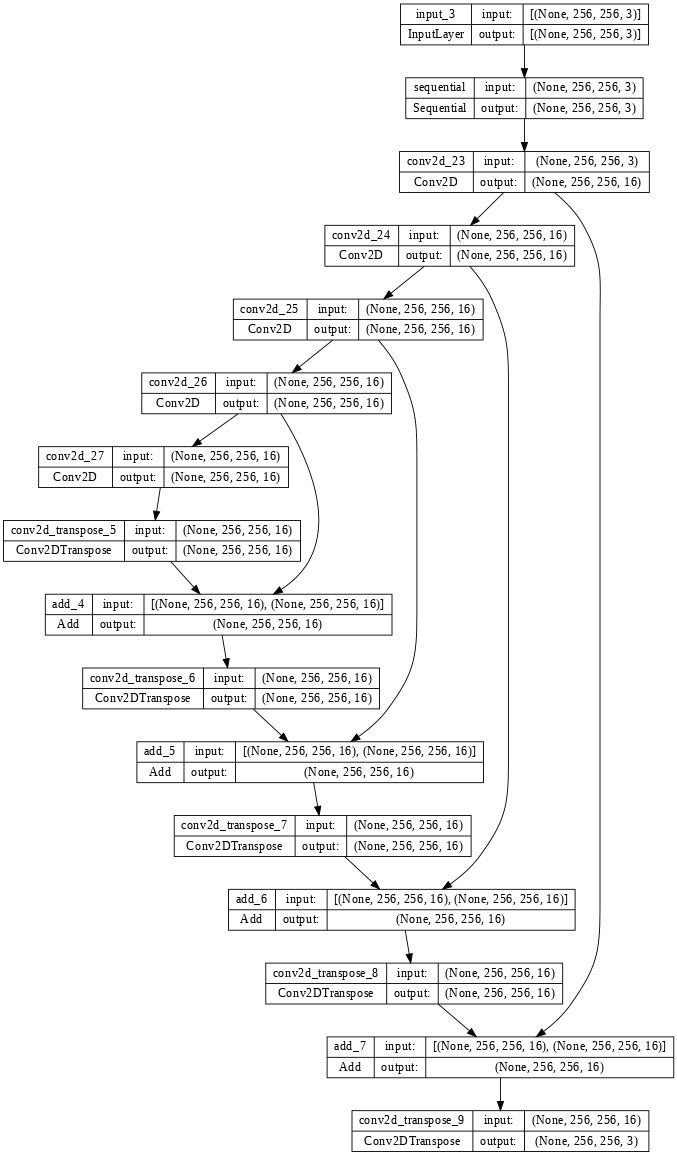

In [42]:
#@title Plot model
from tensorflow.keras.utils import plot_model
autoencoder.summary()
plot_model(autoencoder, show_shapes=True, dpi=64)

In [43]:
#@title Defining optimizers
from tensorflow.keras.optimizers import Adam

autoencoder_optimizer = Adam(0.0001, beta_1=0.9)
autoencoder.compile(optimizer="adam", loss=MeanSquaredError(), metrics=["accuracy"])

In [44]:
#@title Model Checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint

version = "unet_1" #@param {type:"string"}

checkpoint_path = "my_model/gauss" + f"/m_{mean}__v_{var}".replace(".","d") + f"_version_{version}"
monitor = "val_accuracy"
mode = "max"
model_checkpoint = ModelCheckpoint(
    checkpoint_path,
    monitor=monitor,
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode=mode,
)

In [ ]:
#@title Train the model 
EPOCHS = 15
history = autoencoder.fit(traingen,
            validation_data=valgen,
            epochs=EPOCHS,
            shuffle=True,
            callbacks=[model_checkpoint])

Epoch 1/15


47/47 [==============================] - ETA: 0s - loss: 0.0494 - accuracy: 0.4529
Epoch 1: val_accuracy improved from -inf to 0.64860, saving model to my_model/gauss/m_0__v_0d01_version_unet_1
47/47 [==============================] - 141s 3s/step - loss: 0.0494 - accuracy: 0.4529 - val_loss: 0.0149 - val_accuracy: 0.6486
Epoch 2/15
47/47 [==============================] - ETA: 0s - loss: 0.0399 - accuracy: 0.5890
Epoch 2: val_accuracy improved from 0.64860 to 0.71712, saving model to my_model/gauss/m_0__v_0d01_version_unet_1
47/47 [==============================] - 135s 3s/step - loss: 0.0399 - accuracy: 0.5890 - val_loss: 0.0104 - val_accuracy: 0.7171
Epoch 3/15
47/47 [==============================] - ETA: 0s - loss: 0.0391 - accuracy: 0.6152

In [ ]:
#@title Helper function to show results 
def show_results(log):
    val_loss = log.history["val_loss"]
    val_acc = log.history["val_accuracy"]

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    ax1, ax2 = axes
    ax1.plot(log.history["loss"], label="train")
    ax1.plot(val_loss, label="test")
    ax1.set_xlabel("epoch")
    ax1.set_ylabel("loss")
    ax2.plot(log.history["accuracy"], label="train")
    ax2.plot(val_acc, label="test")
    ax2.set_xlabel("epoch")
    ax2.set_ylabel("accuracy")
    for ax in axes:
        ax.legend()

In [ ]:
#@title Show results 
show_results(history)

In [ ]:
#@title Generate Images 
def generate_images(model, test_input, tar):
    prediction = model.predict(test_input.reshape(-1, 256, 256, 3))
    plt.figure(figsize=(15, 15))

    display_list = [
        test_input.astype("float32"),
        tar.astype("float32"),
        prediction.reshape(256, 256, 3),
    ]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])

        plt.axis("off")
        plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))


    plt.show()

In [ ]:
valgen = CustomDataGen(test_df)
print(f"Number of validation batches {len(valgen)}")

In [ ]:
valgen.

In [ ]:
#@title Visualize predictions
# for inp, tar in zip(test_gaussian_noise_images[:5], test_target_images[:5]):
#     generate_images(autoencoder, inp, tar)

for inp, tar in zip(test_gaussian_noise_images1[:5], test_gaussian_noise_images2[:5]):
    generate_images(autoencoder, inp, tar)

In [ ]:
#@title PSNR helper functions 
from math import log10, sqrt


def PSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if mse == 0:
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    return psnr


def plot_comparison(input_image, target_image, prediction):
    plt.figure(figsize=(15, 15))

    display_list = [
        input_image.astype("float32"),
        target_image.astype("float32"),
        prediction.astype("float32"),
    ]
    title = ["Input Image", "Ground Truth", "Predicted Image"]

    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(title[i])
        plt.axis("off")
        plt.imshow(cv2.cvtColor(display_list[i], cv2.COLOR_BGR2RGB))
    plt.show()



In [ ]:
#@title SSIM Helper Functions
def SSIM(original, compressed):
    c1 = (0.01 * 255)**2
    c2 = (0.03 * 255)**2
    mu_x = np.mean(original)
    mu_y = np.mean(compressed)
    sigma_x = (np.var(original))**0.5
    sigma_y = (np.var(compressed))**0.5
    covar = np.mean(original * compressed) - mu_x*mu_y
    ssim = ((2*mu_x*mu_y + c1)*(2*covar + c2)) /((mu_x**2 + mu_y**2 + c1)*(sigma_x**2 + sigma_y**2 + c2)) 
    return ssim

In [ ]:
list_ssim = []

for inp, tar in zip(test_gaussian_noise_images, clean_images_test):
    prediction = autoencoder.predict(inp.reshape(-1, 256, 256, 3))
    prediction = prediction.reshape(256, 256, 3)
    list_ssim.append(SSIM(tar, prediction))

ssim_arr = np.array(list_ssim)
mean_ssim = ssim_arr.mean()

In [ ]:
#@title Find mean PSNR

list_test_predictions = []
list_PSNR = []
for inp, tar in zip(test_gaussian_noise_images, test_target_images):
    prediction = autoencoder.predict(inp.reshape(-1, 256, 256, 3))
    prediction = prediction.reshape(256, 256, 3)
    list_test_predictions.append(prediction)
    list_PSNR.append(PSNR(tar, prediction))
np.array([100 - x for x in list_PSNR]).mean()

In [ ]:
#@title Plot top 5 results
for index in np.array(list_PSNR).argsort()[-5:]:
    plot_comparison(
        test_gaussian_noise_images[index],
        test_target_images[index],
        list_test_predictions[index],
    )

In [ ]:
#@title Save model
opt = "yes" #@param ["yes", "no"]
name = "baseline_flickr8k" #@param [""] {allow-input: true}
!mkdir models
opt = input("Do you want to save the model[yes/no]?")
if opt == "yes":
    fileName = "models/" + f"/m_{mean}__v_{var}".replace(".","d") + f"_version_{version}" + name + ".h"
    if os.path.isfile(fileName) is False:
        autoencoder.save(fileName)

In [ ]:
#@title Save tf lite 
converter = tf.lite.TFLiteConverter.from_keras_model(autoencoder)
tflite_model = converter.convert()
tf_lite_name = "models_tf_lite/" + f"/m_{mean}__v_{var}".replace(".","d") + f"_version_{version}" + name + ".h"
with open(f"model_{name}.tflite", 'wb') as f:
  f.write(tflite_model)